In [1]:
import fig02 as src
import pandas as pd
import seaborn as sns
from IPython.display import display

pd.set_option("display.float_format", "{:.4f}".format)

signature_list = ["nps", "siips", "na-gen", "na-therm", "na-mech", "na-sound", "na-vis"]

cols = ["sub", "task", "group", "int", "unp"]

# visual analog scale
vas = (
    pd.concat(
        [
            pd.read_csv("../../results/cbf-ps-agg.csv").query(
                "task.str.endswith('49C') and (group == 'm' or group == 'c')"
            )[cols],
            pd.read_csv("../../results/bold-ps-agg.csv")[cols],
        ]
    )
    .groupby("sub")
    .filter(lambda df: df["task"].nunique() == 3)  # filter missing data
    .melt(id_vars=["sub", "task", "group"], value_vars=["int", "unp"])
)

# blood oxygen level dependent imaging
bold = (
    pd.read_csv("../../results/bold-ps-agg.csv")
    .query("FD < 0.5")  # also drops NaN
    .pipe(src.scale, signature_list)  # zscore by study
)

# cerebral blood flow imaging
cbf = (
    pd.read_csv("../../results/cbf-ps-agg.csv")
    .query("task.str.endswith('49C') and group != 's'")  # select 49C runs
    .pipe(src.drop_outliers, "cbfQEI")  # -1.5 * IQR
    .pipe(src.scale, signature_list)  # zscore by study
)

# brain pattern responses
bpr = (
    pd.concat([cbf.query("ses == 'mri2'"), bold])
    .groupby("sub", as_index=False, group_keys=True)
    .apply(src.get_residual)
    .melt(
        id_vars=["sub", "task", "group", "int", "int_residual", "unp"],
        value_vars=signature_list,
    )
)


bpr.groupby("group")["sub"].nunique()


/usr/local/Caskroom/miniconda/base/envs/med-pain-sig/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


group
c    39
l    20
m    38
Name: sub, dtype: int64

group x manipulation plots

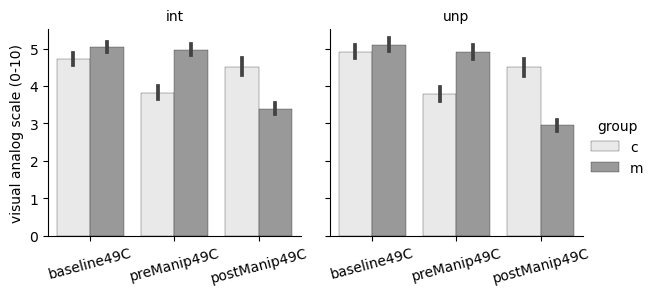

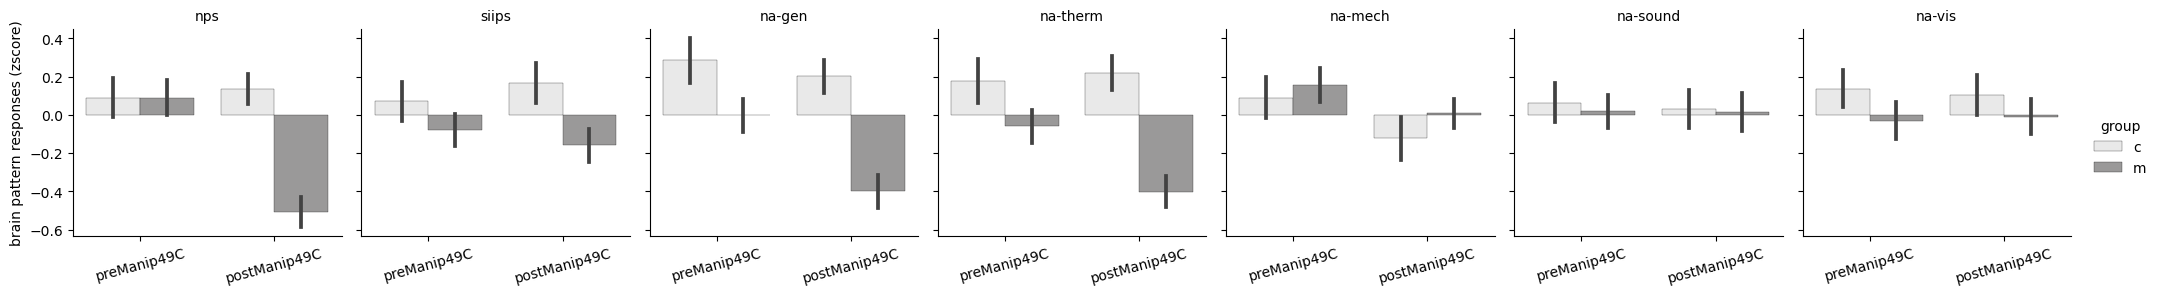

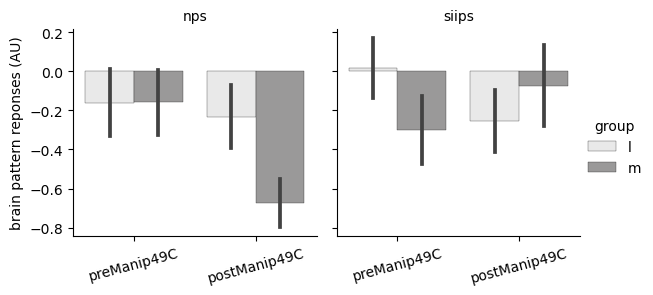

In [2]:
# visual analog scale
vas_plot = src.plot_group_by_manipulation(
    vas, col_order=["int", "unp"], order=["baseline49C", "preManip49C", "postManip49C"]
)
vas_plot.set_ylabels("visual analog scale (0-10)")
vas_plot.savefig("../../figures/fig02-pain-ratings.png", dpi=300)

# brain pattern responses
bpr_plot = src.plot_group_by_manipulation(
    bpr.query("group == 'c' or group == 'm'"), col_order=signature_list
)
bpr_plot.set_ylabels("brain pattern responses (zscore)")
bpr_plot.savefig("../../figures/fig02-brain-pattern-responses.png", dpi=300)

# mindfulness vs placebo
mm_vs_placebo_plot = src.plot_group_by_manipulation(
    bpr.query(
        "sub.str.startswith('cbf') and (variable == 'nps' or variable == 'siips') and group != 'c'"
    ),
    col_order=["nps", "siips"],
)
mm_vs_placebo_plot.set_ylabels("brain pattern reponses (AU)")
mm_vs_placebo_plot.savefig("../../figures/fig02-mm-vs-placebo.png", dpi=300)


pain ratings vs brain pattern response

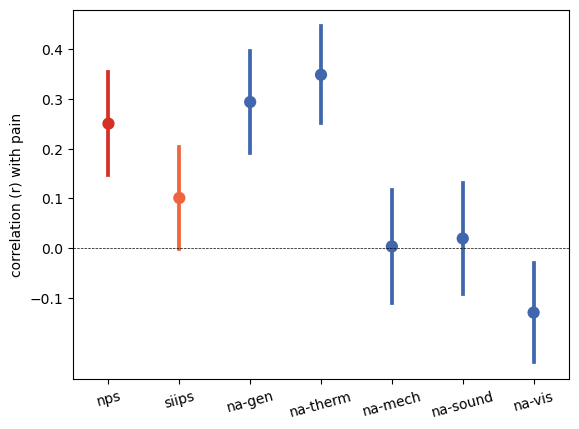

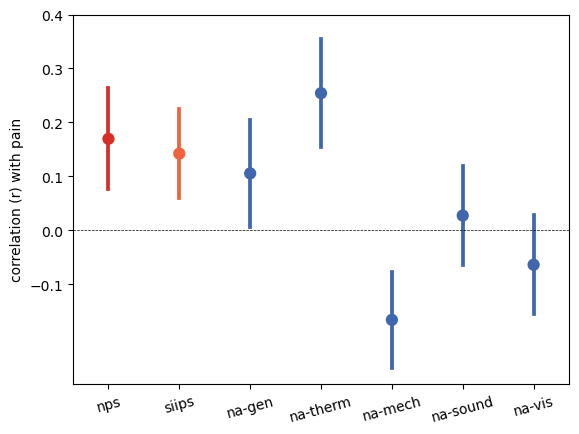

In [3]:
corrwith_pain = (
    bpr.query("group == 'c' or group == 'm'")
    .groupby("sub")
    .filter(lambda df: df["task"].nunique() == 2)
    .groupby(["group", "sub", "variable"], as_index=False)
    .apply(src.get_corrwith_pain)
)

m = src.plot_correlations(corrwith_pain.query("group == 'm'"), order=signature_list)
m.savefig("../../figures/fig02-corrwith-pain-m.png", dpi=300)

c = src.plot_correlations(corrwith_pain.query("group == 'c'"), order=signature_list)
c.savefig("../../figures/fig02-corrwith-pain-c.png", dpi=300)


a. mixed ANOVA: VAS pain ratings

In [4]:
mixed_anova_df, pairwise_ttests_df = src.mixed_anova(
    vas.query("task != 'baseline49C'"),  # post-intervention
)
display(
    mixed_anova_df.style.background_gradient(cmap="Blues", subset=["np2"]),
    pairwise_ttests_df,
)


Contrast group             A            B Paired  Parametric  \
variable                                                                       
int      2  group * task     c  postManip49C  preManip49C   True        True   
         3  group * task     m  postManip49C  preManip49C   True        True   
unp      2  group * task     c  postManip49C  preManip49C   True        True   
         3  group * task     m  postManip49C  preManip49C   True        True   

                 T     dof alternative  p-unc  q-fdr       BF10   cohen  
variable                                                                 
int      2  3.2857 37.0000   two-sided 0.0022 0.0022     15.242  0.3154  
         3 -6.4907 37.0000   two-sided 0.0000 0.0000  1.103e+05 -0.9512  
unp      2  3.6659 37.0000   two-sided 0.0008 0.0010     39.166  0.3368  
         3 -6.6298 37.0000   two-sided 0.0000 0.0000  1.653e+05 -1.0976

b. one sample ttest: correlation (r) with pain

In [5]:
display(
    src.one_sample_ttest(corrwith_pain.query("group == 'm'")),
    src.one_sample_ttest(corrwith_pain.query("group == 'c'")),
)


T  dof alternative  p-val  q-fdr          CI95%  \
group variable                                                                
m     na-gen   T-test  2.8965   35   two-sided 0.0065 0.0226    [0.09, 0.5]   
      na-mech  T-test  0.0337   35   two-sided 0.9733 0.9733  [-0.23, 0.23]   
      na-sound T-test  0.1774   35   two-sided 0.8602 0.9733  [-0.21, 0.25]   
      na-therm T-test  3.5842   35   two-sided 0.0010 0.0071   [0.15, 0.55]   
      na-vis   T-test -1.2908   35   two-sided 0.2052 0.3591  [-0.33, 0.07]   
      nps      T-test  2.4135   35   two-sided 0.0212 0.0494   [0.04, 0.46]   
      siips    T-test  0.9912   35   two-sided 0.3284 0.4597  [-0.11, 0.31]   

                       cohen-d    BF10  power  
group variable                                 
m     na-gen   T-test   0.4828   6.148 0.8041  
      na-mech  T-test   0.0056   0.179 0.0501  
      na-sound T-test   0.0296   0.182 0.0534  
      na-therm T-test   0.5974  30.958 0.9363  
      na-vis   T-test   0.2151   0.384 0.2412  
      nps      T-test   0.4022    2.25 0.6506  
      siips    T-test   0.1652   0.282 0.1614

T  dof alternative  p-val  q-fdr          CI95%  \
group variable                                                                
c     na-gen   T-test  1.0651   38   two-sided 0.2936 0.4110   [-0.1, 0.31]   
      na-mech  T-test -1.8719   38   two-sided 0.0689 0.1593  [-0.35, 0.01]   
      na-sound T-test  0.2993   38   two-sided 0.7663 0.7663  [-0.16, 0.21]   
      na-therm T-test  2.5298   38   two-sided 0.0157 0.1098   [0.05, 0.46]   
      na-vis   T-test -0.6988   38   two-sided 0.4889 0.5704  [-0.25, 0.12]   
      nps      T-test  1.8071   38   two-sided 0.0787 0.1593  [-0.02, 0.36]   
      siips    T-test  1.7339   38   two-sided 0.0910 0.1593  [-0.02, 0.31]   

                       cohen-d   BF10  power  
group variable                                
c     na-gen   T-test   0.1705  0.292 0.1797  
      na-mech  T-test   0.2997  0.837 0.4462  
      na-sound T-test   0.0479   0.18 0.0598  
      na-therm T-test   0.4051  2.809 0.6934  
      na-vis   T-test   0.1119  0.217 0.1046  
      nps      T-test   0.2894  0.755 0.4214  
      siips    T-test   0.2776  0.674 0.3938

c. mixed ANOVA: brain pattern responses

In [6]:
mixed_anova_df, pairwise_ttests_df = src.mixed_anova(bpr.query("group == 'm' or group == 'c'"))
display(
    mixed_anova_df.style.background_gradient(cmap="Blues", subset=["np2"]),
    pairwise_ttests_df,
)


Contrast group             A            B Paired  Parametric  \
variable                                                                       
na-gen   2  group * task     c  postManip49C  preManip49C   True        True   
         3  group * task     m  postManip49C  preManip49C   True        True   
na-therm 2  group * task     c  postManip49C  preManip49C   True        True   
         3  group * task     m  postManip49C  preManip49C   True        True   
nps      2  group * task     c  postManip49C  preManip49C   True        True   
         3  group * task     m  postManip49C  preManip49C   True        True   

                 T     dof alternative  p-unc  q-fdr      BF10   cohen  
variable                                                                
na-gen   2 -0.3846 38.0000   two-sided 0.7026 0.8788     0.185 -0.0508  
         3 -4.4331 35.0000   two-sided 0.0001 0.0003   280.928 -0.5692  
na-therm 2  0.3446 38.0000   two-sided 0.7323 0.8788     0.182  0.0415  
         3 -3.7205 35.0000   two-sided 0.0007 0.0014    43.539 -0.6009  
nps      2  0.1327 38.0000   two-sided 0.8951 0.8951     0.174  0.0159  
         3 -5.4167 35.0000   two-sided 0.0000 0.0000  4248.138 -0.8610

d. mixed ANOVA: mindfulness vs placebo

In [7]:
mixed_anova_df, pairwise_ttests_df = src.mixed_anova(
    bpr.query(
        "sub.str.startswith('cbf') and (variable == 'nps' or variable == 'siips') and group != 'c'"
    )
)
display(
    mixed_anova_df.style.background_gradient(cmap="Blues", subset=["np2"]),
    pairwise_ttests_df,
)


Contrast group             A            B Paired  Parametric  \
variable                                                                       
nps      2  group * task     l  postManip49C  preManip49C   True        True   
         3  group * task     m  postManip49C  preManip49C   True        True   
siips    2  group * task     l  postManip49C  preManip49C   True        True   
         3  group * task     m  postManip49C  preManip49C   True        True   

                 T     dof alternative  p-unc  q-fdr   BF10   cohen  
variable                                                             
nps      2 -0.5037 18.0000   two-sided 0.6206 0.6206  0.266 -0.0630  
         3 -3.4898 16.0000   two-sided 0.0030 0.0121  14.64 -0.8559  
siips    2 -2.3617 18.0000   two-sided 0.0297 0.0396  2.139 -0.2740  
         3  2.6879 16.0000   two-sided 0.0162 0.0323  3.622  0.3048